In [63]:
from bciaut_to_mne import convert_to_mne
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from mne import concatenate_epochs

if not os.path.exists('data'):
    kaggle = KaggleApi()
    kaggle.authenticate()
    kaggle.dataset_download_cli(dataset='disbeat/bciaut-p300',
                                unzip=True)
epochs = convert_to_mne('data/SBJ01/S01/Train/trainData.mat')
epochs

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1600 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Number of events,1600
Events,stimulus/1: 200stimulus/2: 200stimulus/3: 200stimulus/4: 200stimulus/5: 200stimulus/6: 200stimulus/7: 200stimulus/8: 200
Time range,-0.200 – 1.196 sec
Baseline,off


In [64]:
epochs.filter(l_freq=None, h_freq=16)
epochs.crop(tmin=0, tmax=1.0)

Setting up low-pass filter at 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 207 samples (0.828 sec)



Number of events,1600
Events,stimulus/1: 200stimulus/2: 200stimulus/3: 200stimulus/4: 200stimulus/5: 200stimulus/6: 200stimulus/7: 200stimulus/8: 200
Time range,0.000 – 1.000 sec
Baseline,off


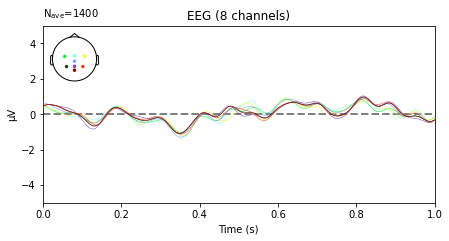

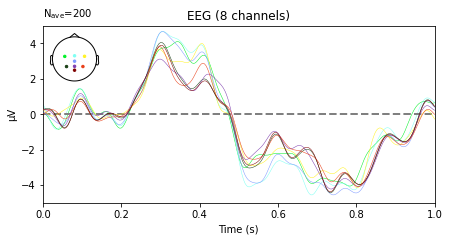

In [65]:
avg_not_selected = epochs['stimulus != cue'].average()
avg_not_selected.plot(spatial_colors=True, ylim=dict(eeg=[-5,5]), hline=[0])

avg_selected = epochs['stimulus == cue'].average()
avg_selected.plot(spatial_colors=True, ylim=dict(eeg=[-5,5]), hline=[0]);

In [66]:
from mne.decoding import Scaler
from mne import EpochsArray

scaler = Scaler(epochs.info, scalings='median')
epochs_data = scaler.fit_transform(epochs.get_data())
epochs = EpochsArray(epochs_data, info=epochs.info, tmin=epochs.tmin,
                     events=epochs.events, event_id=epochs.event_id,
                     metadata=epochs.metadata)

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
1600 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


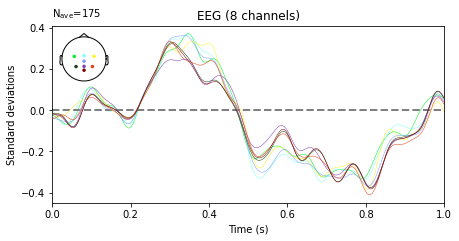

In [67]:
from mne import combine_evoked

activation_pattern = combine_evoked([epochs['stimulus == cue'].average(),
                                     epochs['stimulus != cue'].average()],
                                    weights=[1,-1])
activation_pattern.plot(spatial_colors=True,scalings=dict(eeg=1),
                        units=dict(eeg='Standard deviations'),
                        hline=[0]);

In [68]:
from mcbf.alg.beamformer import LCMVBeamformer

stbf = LCMVBeamformer(lead_field=activation_pattern._data,
                      cov_estimator='lw')
stbf.fit(epochs.get_data());

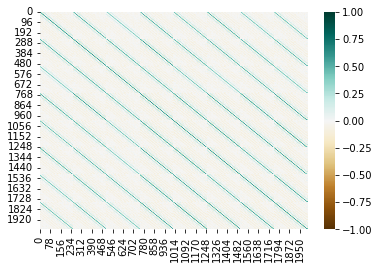

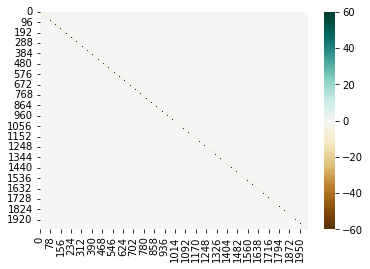

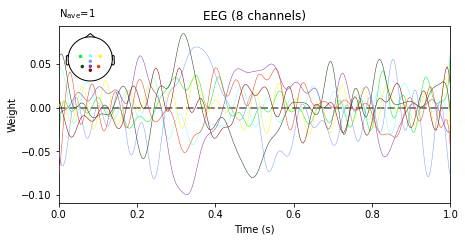

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
from mne import EvokedArray

sns.heatmap(stbf.cov_estimator_.covariance_,
            cmap='BrBG', vmin=-1, vmax=1)
plt.show()
sns.heatmap(stbf.cov_estimator_.precision_,
            cmap='BrBG', vmin=-60, vmax=60)
plt.show()
weights_evoked = EvokedArray(stbf.weights_, epochs.info, epochs.tmin)
weights_evoked.plot(spatial_colors=True,scalings=dict(eeg=1),
                        units=dict(eeg='Weight'), hline=[0]);

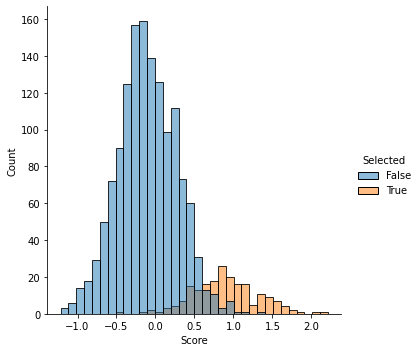

In [70]:
import pandas as pd
scores = stbf.transform(epochs.get_data()).squeeze()
labels = epochs.metadata['stimulus'] == epochs.metadata['cue']
result = pd.DataFrame({
    'Score': scores,
    'Selected': labels,
})
sns.displot(data=result, x='Score', hue='Selected')